In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv("test.csv")
df.columns = df.columns.str.strip()
df['time'] = pd.to_datetime(df['time'])  # Convert 'time' column to datetime type

df = df.dropna()
print(df['Close'].isnull().sum())

0


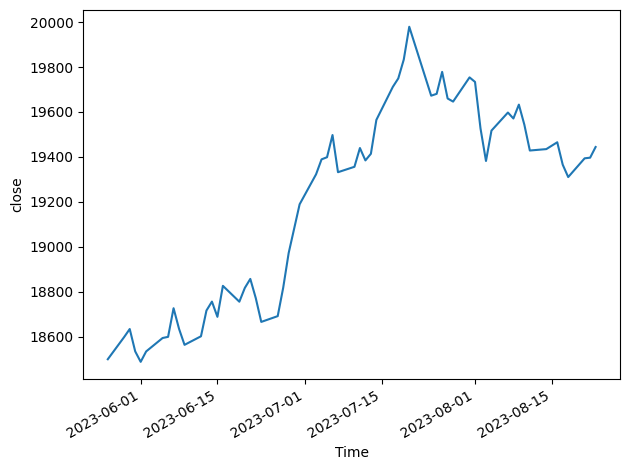

In [3]:
fig, ax = plt.subplots()

ax.plot(df.time, df['Close'])
ax.set_xlabel('Time')
ax.set_ylabel('close')


fig.autofmt_xdate()
plt.tight_layout()



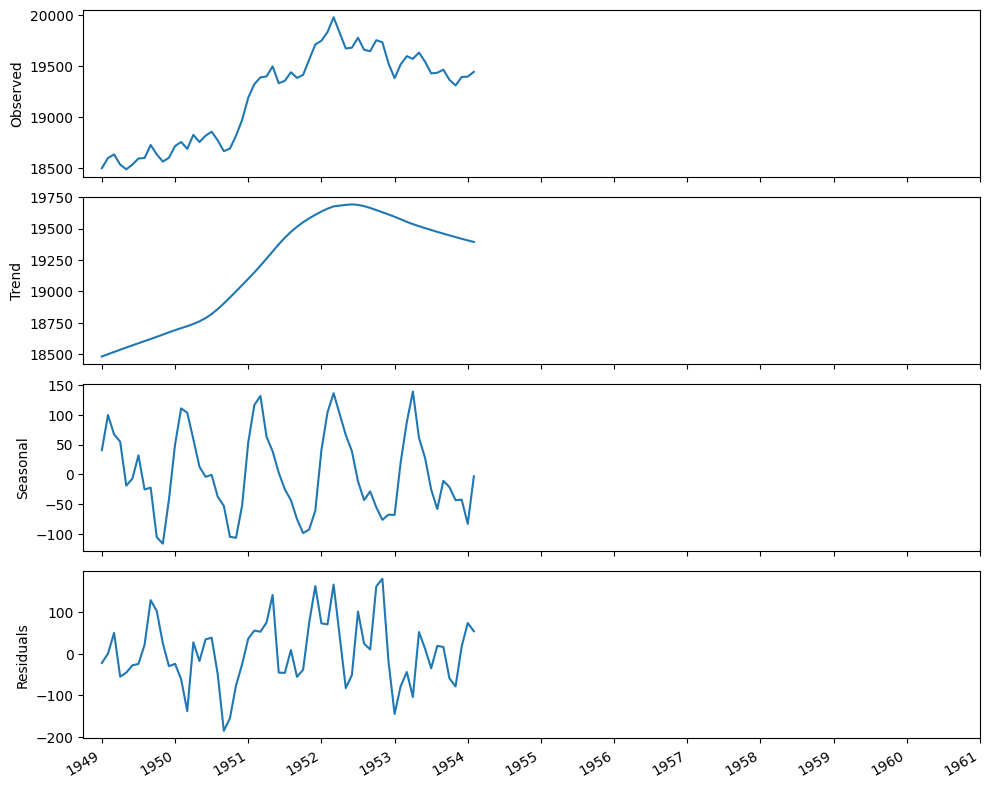

In [4]:
decomposition = STL(df['Close'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

In [5]:
ad_fuller_result = adfuller(df['Close'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.5002577643664798
p-value: 0.533383822711605


In [7]:
df_diff = np.diff(df['Close'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.7849986778453735
p-value: 0.003064581747323089


In [8]:
df_diff_seasonal_diff = np.diff(df_diff, n=30)

ad_fuller_result = adfuller(df_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -14.466970565125328
p-value: 6.702082586235242e-27


In [9]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [10]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [17]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['Close'][:-30]

d = 1
D = 1
s = 30

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(0, 0, 0, 0)",2.0
1,"(0, 0, 0, 1)",4.0
2,"(0, 1, 0, 0)",4.0
3,"(1, 0, 0, 0)",4.0
4,"(0, 2, 0, 0)",6.0
...,...,...
202,"(3, 2, 3, 3)",24.0
203,"(3, 3, 2, 3)",24.0
204,"(2, 3, 3, 3)",24.0
205,"(3, 3, 3, 2)",24.0


In [12]:
df.tail()

,time,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr)
57,2023-08-17,19450.55,19461.55,19326.25,19365.25,268663456.0,26505.65
58,2023-08-18,19301.75,19373.80,19253.60,19310.15,256142364.0,25641.41
59,2023-08-21,19320.65,19425.95,19296.30,19393.60,262589133.0,20738.75
60,2023-08-22,19417.10,19443.50,19381.30,19396.45,208704354.0,20226.48
61,2023-08-23,19439.20,19472.05,19366.60,19444.00,225214991.0,20167.16


In [16]:
test = df.iloc[-30:]

test['naive_seasonal'] = df['Close'].iloc[1:31].values
test

,time,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr),naive_seasonal
31,2023-07-11,19427.10,19515.10,19406.45,19439.40,251263638.0,26883.78,18598.65
32,2023-07-12,19497.45,19507.70,19361.75,19384.30,327941559.0,40163.14,18633.85
33,2023-07-13,19495.20,19567.00,19385.80,19413.75,310442517.0,27244.56,18534.40
34,2023-07-14,19493.45,19595.35,19433.50,19564.50,291165841.0,25484.44,18487.75
35,2023-07-17,19612.15,19731.85,19562.95,19711.45,268707894.0,25975.57,18534.10
36,2023-07-18,19787.50,19819.45,19690.20,19749.25,286353897.0,33269.08,18593.85
37,2023-07-19,19802.95,19851.70,19727.45,19833.15,259660464.0,26447.90,18599.00
38,2023-07-20,19831.70,19991.85,19758.40,19979.15,274698867.0,30622.66,18726.40
40,2023-07-24,19748.45,19782.75,19658.30,19672.35,265562151.0,24522.29,18634.55
41,2023-07-25,19729.35,19729.35,19615.95,19680.60,369653496.0,29665.67,18563.40


In [18]:
SARIMA_model = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                   Close   No. Observations:                   31
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -112.165
Date:                                 Sun, 27 Aug 2023   AIC                            238.330
Time:                                         12:42:02   BIC                            244.563
Sample:                                              0   HQIC                           239.190
                                                  - 31                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6531      1.015     -0.644      0.520      -2.642       1

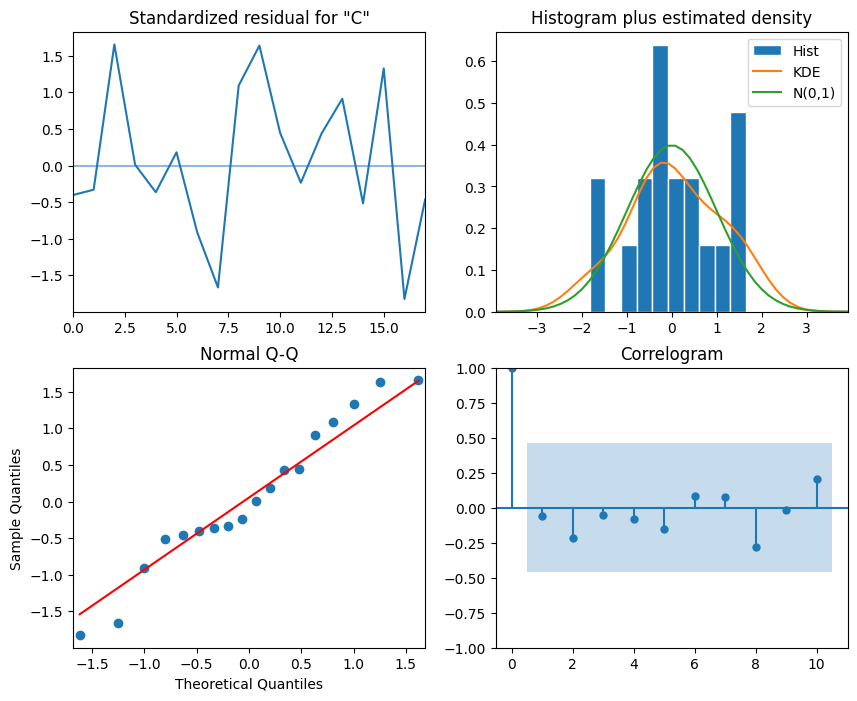

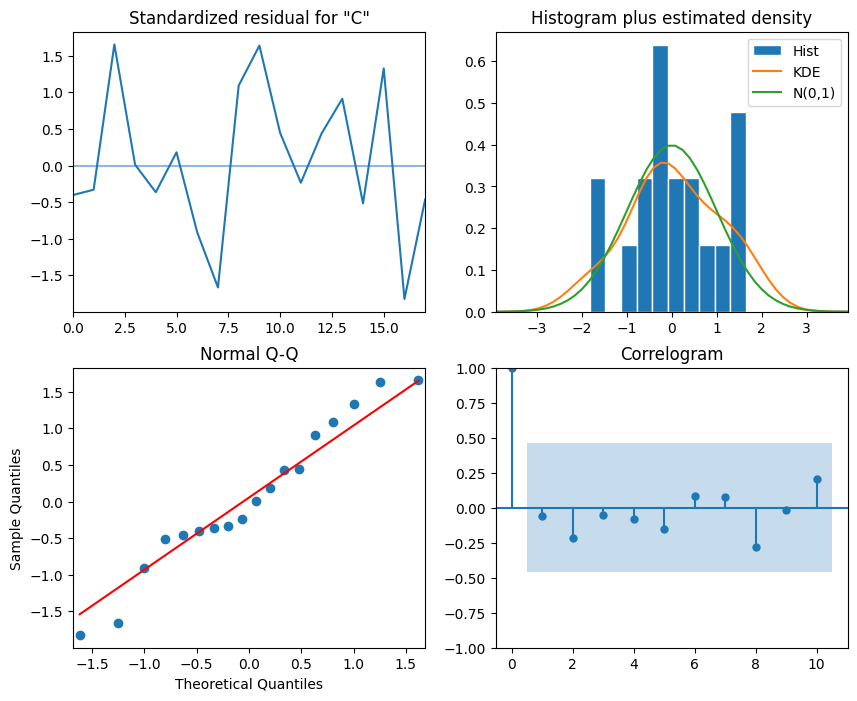

In [20]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

#plt.savefig('figures/CH08_F12_peixeiro.png', dpi=300)

In [24]:
residuals = SARIMA_model_fit.resid
pvalue=[]
pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

     lb_stat  lb_pvalue
1   0.003835   0.950620
2   0.006277   0.996867
3   0.006284   0.999868
4   0.006284   0.999995
5   0.009127   1.000000
6   0.010512   1.000000
7   0.012513   1.000000
8   0.023824   1.000000
9   0.023833   1.000000
10  0.024175   1.000000


In [25]:
SARIMA_pred = SARIMA_model_fit.get_prediction(31, 60).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

,time,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr),naive_seasonal,SARIMA_pred
31,2023-07-11,19427.10,19515.10,19406.45,19439.40,251263638.0,26883.78,18598.65,19233.511317
32,2023-07-12,19497.45,19507.70,19361.75,19384.30,327941559.0,40163.14,18633.85,19265.346234
33,2023-07-13,19495.20,19567.00,19385.80,19413.75,310442517.0,27244.56,18534.40,19196.527919
34,2023-07-14,19493.45,19595.35,19433.50,19564.50,291165841.0,25484.44,18487.75,19297.593950
35,2023-07-17,19612.15,19731.85,19562.95,19711.45,268707894.0,25975.57,18534.10,19379.985094
36,2023-07-18,19787.50,19819.45,19690.20,19749.25,286353897.0,33269.08,18593.85,19692.338436
37,2023-07-19,19802.95,19851.70,19727.45,19833.15,259660464.0,26447.90,18599.00,19779.414304
38,2023-07-20,19831.70,19991.85,19758.40,19979.15,274698867.0,30622.66,18726.40,19831.317790
40,2023-07-24,19748.45,19782.75,19658.30,19672.35,265562151.0,24522.29,18634.55,19828.746375
41,2023-07-25,19729.35,19729.35,19615.95,19680.60,369653496.0,29665.67,18563.40,19767.686089


In [26]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [27]:
mape_naive_seasonal = mape(test['Close'], test['naive_seasonal'])

mape_SARIMA = mape(test['Close'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_SARIMA)

3.7537693324100716 2.1569435914400015
